In [1]:
# Import dependencies and allow access to google drive (store dataset here)
from google.colab import drive
drive.mount('/content/drive')

!pip install -q pytorch_msssim

import torch
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from pytorch_msssim import SSIM
from tqdm import tqdm

Mounted at /content/drive


In [111]:
# MAIN CODE BLOCK - Full dataset image patch attack, with SSIM

# THIS CODE GENERATES A FGSM PATCH ATTACK, takes in a patch_size, epsilon value, and steps (iterations)
# you can also alter the location of the patch by simply changing the values of center_h and center_w, this determines where the
# center of the patch is located with respect to the RAW input image of size 448x448

# This DOES incorporate SSIM into the loss function


def create_adversarial_image(original_image, patch_size, epsilon, steps):
    """
    Create an adversarial image by adding a patch to the Bayer image,
    using SSIM as the loss function to generate the patch.

    Args:
        original_image (np.ndarray): The original RAW image of shape (448, 448).
        patch_size (int): The size of the adversarial patch.

    Returns:
        np.ndarray: The adversarial image in RAW format.
    """
    # Convert the original image to a Bayer image
    bayer_image = np.array(Image.fromarray(original_image).convert('L'))

    # Initialize the patch with random values
    patch = np.random.rand(patch_size, patch_size) * 255
    patch = patch.astype(np.uint8)

    # Determine the center coordinates of the patch
    height, width = bayer_image.shape
    center_h = 224
    center_w = 224

    # Create a new image with the patch added
    adv_image = np.copy(bayer_image)
    adv_image_patch = np.zeros_like(bayer_image)
    adv_image_patch[center_h - patch_size // 2:center_h + patch_size // 2, center_w - patch_size // 2:center_w + patch_size // 2] = patch
    adv_image = np.maximum(adv_image, adv_image_patch)

    # Convert the adversarial image to a tensor
    adv_image_tensor = torch.from_numpy(adv_image).unsqueeze(0).unsqueeze(0).float()

    # Calculate the SSIM loss between the original and adversarial images
    ssim_loss = 1.0 - SSIM(data_range=1.0, size_average=True, channel=1)(adv_image_tensor, adv_image_tensor)

    # Generate the patch using the SSIM loss as the objective function
    for _ in range(steps):  # Run for designated amount of steps
        # Update the patch values to minimize the SSIM loss
        patch = patch.astype(np.float64)
        patch -= epsilon * np.sign(ssim_loss.detach().numpy())
        patch = np.clip(patch, 0, 255)

        # Update the adversarial image with the new patch values
        adv_image_patch[center_h - patch_size // 2:center_h + patch_size // 2, center_w - patch_size // 2:center_w + patch_size // 2] = patch
        adv_image = np.maximum(adv_image, adv_image_patch)

        # Recalculate the SSIM loss with the updated patch
        adv_image_tensor = torch.from_numpy(adv_image).unsqueeze(0).unsqueeze(0).float()
        ssim_loss = 1.0 - SSIM(data_range=1.0, size_average=True, channel=1)(adv_image_tensor, adv_image_tensor)

    # Convert the adversarial image back to RAW format
    #adv_image_raw = np.array(Image.fromarray(adv_image).convert('RGB'))

    return adv_image

# Load the dataset of images
image_folder = '/content/drive/MyDrive/p9/ZRR_Dataset/sub_RAW'
adversarial_folder = '/content/drive/MyDrive/p9/ZRR_Dataset/attacked_images1/'
images = os.listdir(image_folder)

# Create the adversarial images and save them to the adversarial folder
for image_name in tqdm(images, desc='Creating adversarial images'):
    original_image = np.array(Image.open(os.path.join(image_folder, image_name)))
    bayer_image1 = np.array(Image.fromarray(original_image).convert('L'))
    adv_image = create_adversarial_image(original_image, patch_size=250, epsilon=0.3, steps=100)
    Image.fromarray(adv_image).save(os.path.join(adversarial_folder, image_name))

# Display the adversarial images
#adversarial_images = os.listdir(adversarial_folder)
#for i, image_name in enumerate(adversarial_images):
#    adv_image = np.array(Image.open(os.path.join(adversarial_folder, image_name)))
#    plt.imshow(adv_image, cmap='gray')
#    plt.title(f'Adversarial Image {i}')
#    plt.show()


Creating adversarial images: 100%|██████████| 58/58 [03:30<00:00,  3.63s/it]


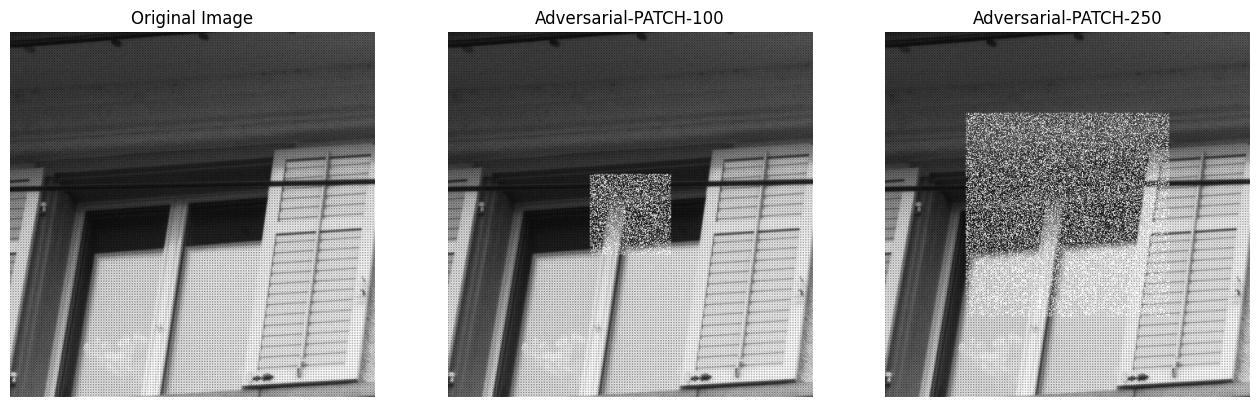

<Figure size 640x480 with 0 Axes>

In [4]:
# EXTRA CODE BLOCK 1 - Single image patch attack, with SSIM

# THIS CODE GENERATES A FGSM PATCH ATTACK, takes in a patch_size, epsilon value, and steps (iterations)
# This DOES incorporate SSIM into the loss function

import torch
import tensorflow as tf
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from pytorch_msssim import SSIM

def create_adversarial_image(original_image, patch_size, epsilon, steps):
    """
    Create an adversarial image by adding a patch to the Bayer image,
    using SSIM as the loss function to generate the patch.

    Args:
        original_image (np.ndarray): The original RAW image of shape (448, 448).
        patch_size (int): The size of the adversarial patch.

    Returns:
        np.ndarray: The adversarial image in RAW format.
    """
    # Convert the original image to a Bayer image
    bayer_image = np.array(Image.fromarray(original_image).convert('L'))

    # Initialize the patch with random values
    patch = np.random.rand(patch_size, patch_size) * 255
    patch = patch.astype(np.uint8)

    # Determine the center coordinates of the patch
    height, width = bayer_image.shape
    center_h = 224
    center_w = 224

    # Create a new image with the patch added
    adv_image = np.copy(bayer_image)
    adv_image_patch = np.zeros_like(bayer_image)
    adv_image_patch[center_h - patch_size // 2:center_h + patch_size // 2, center_w - patch_size // 2:center_w + patch_size // 2] = patch
    adv_image = np.maximum(adv_image, adv_image_patch)

    # Convert the adversarial image to a tensor
    adv_image_tensor = torch.from_numpy(adv_image).unsqueeze(0).unsqueeze(0).float()

    # Calculate the SSIM loss between the original and adversarial images
    ssim_loss = 1.0 - SSIM(data_range=1.0, size_average=True, channel=1)(adv_image_tensor, adv_image_tensor)

    # Generate the patch using the SSIM loss as the objective function
    for _ in range(steps):  # Run for designated amount of steps
        # Update the patch values to minimize the SSIM loss
        patch = patch.astype(np.float64)
        patch -= epsilon * np.sign(ssim_loss.detach().numpy())
        patch = np.clip(patch, 0, 255)

        # Update the adversarial image with the new patch values
        adv_image_patch[center_h - patch_size // 2:center_h + patch_size // 2, center_w - patch_size // 2:center_w + patch_size // 2] = patch
        adv_image = np.maximum(adv_image, adv_image_patch)

        # Recalculate the SSIM loss with the updated patch
        adv_image_tensor = torch.from_numpy(adv_image).unsqueeze(0).unsqueeze(0).float()
        ssim_loss = 1.0 - SSIM(data_range=1.0, size_average=True, channel=1)(adv_image_tensor, adv_image_tensor)

    # Convert the adversarial image back to RAW format
    adv_image_raw = np.array(Image.fromarray(adv_image).convert('RGB'))

    return adv_image, adv_image_raw

# Load the original RAW image
original_image = np.array(Image.open('/content/drive/MyDrive/p9/ZRR_Dataset/1157.png'))
bayer_image = np.array(Image.fromarray(original_image).convert('L'))

# Create the adversarial image - PATCH SIZE of 100
adv_image1, adv_image_raw1 = create_adversarial_image(original_image, patch_size=100, epsilon=0.3, steps=100)

# Create the adversarial image - PATCH SIZE of 250
adv_image2, adv_image_raw2 = create_adversarial_image(original_image, patch_size=250, epsilon=0.3, steps=100)

# Display the original (bayer form) image
plt.figure(figsize=(16, 16))
plt.subplot(1, 3, 1)
plt.imshow(bayer_image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(adv_image1, cmap='gray')
plt.title('Adversarial-PATCH-100')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(adv_image2, cmap='gray')
plt.title('Adversarial-PATCH-250')
plt.axis('off')
plt.show()

# Save the plot
plt.savefig('/content/drive/MyDrive/p9/adversarial_images.png', dpi=300)
plt.show()

SSIM: 0.7564500570297241


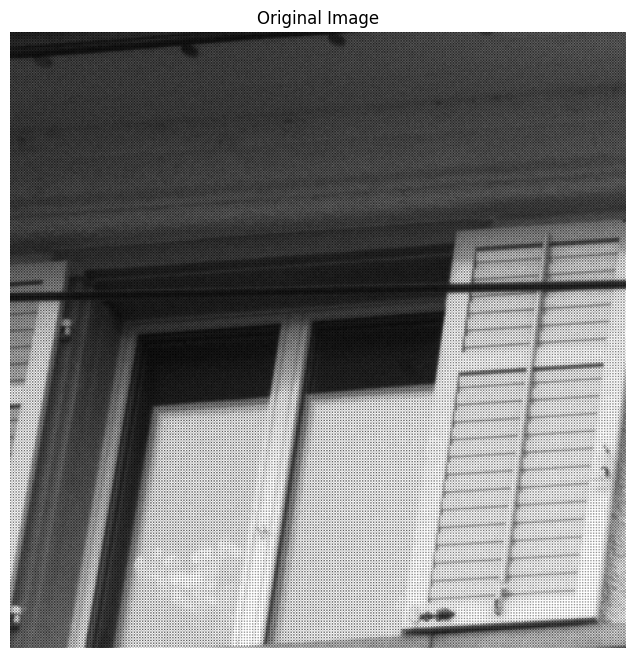

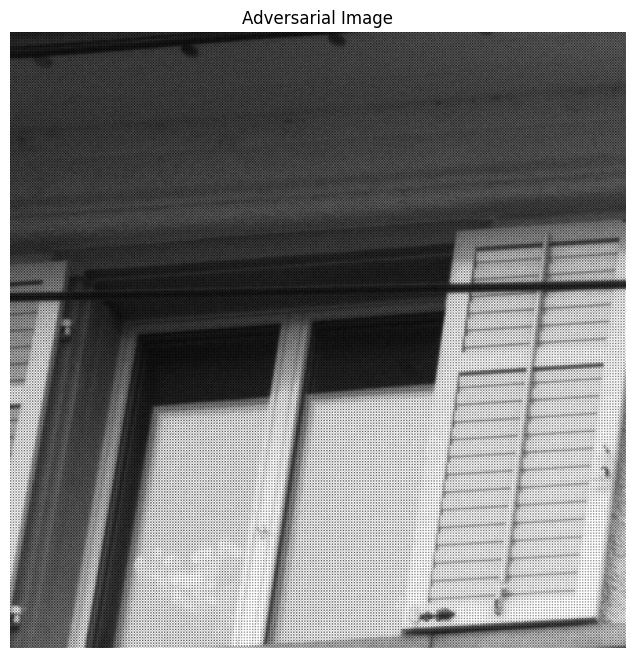

In [73]:
# EXTRA CODE BLOCK 2 - Single full image attack, with SSIM

# THIS CODE GENERATES A FGSM FULL IMAGE ATTACK, full image means the entire image gets perturbed not just a specific portion/patch
# This DOES incorporate SSIM into the loss function


import tensorflow as tf
import numpy as np
from PIL import Image
import torch
from pytorch_msssim import SSIM

def generate_adversarial_example(original_image, eps, steps):
    """
    Generate an adversarial example using the Fast Gradient Sign Method (FGSM) with SSIM loss.

    Args:
        original_image (np.ndarray): The original grayscale RAW image of shape (448, 448).
        eps (float): The maximum perturbation size.
        steps (int): The number of gradient descent steps to perform.

    Returns:
        np.ndarray: The adversarial example.
    """
    # Convert the image to a TensorFlow tensor
    original_image_tensor = tf.expand_dims(tf.expand_dims(tf.convert_to_tensor(original_image, dtype=tf.float32), axis=0), axis=-1)

    # Initialize the perturbation tensor
    perturbation = tf.zeros_like(original_image_tensor)

    # Perform the FGSM attack with SSIM loss
    for _ in range(steps):
        with tf.GradientTape() as tape:
            tape.watch(perturbation)

            # Construct the adversarial example
            adversarial_image = tf.clip_by_value(original_image_tensor + perturbation, 0.0, 1.0)

            # Calculate the SSIM loss
            ssim_loss = 1.0 - tf.image.ssim(original_image_tensor, adversarial_image, max_val=1.0)

        # Calculate the gradients of the loss with respect to the perturbation
        gradients = tape.gradient(ssim_loss, perturbation)

        # Update the perturbation
        perturbation += tf.sign(gradients) * eps
        perturbation = tf.clip_by_value(perturbation, -eps, eps)

    # Return the adversarial example
    return (original_image_tensor + perturbation)[0, :, :, 0].numpy()

# Load the original image
original_image = Image.open('/content/drive/MyDrive/p9/ZRR_Dataset/1157.png')
bayer_image = np.array(original_image.convert('L'))

# Generate the adversarial example
adversarial_image = generate_adversarial_example(bayer_image, eps=0.88, steps=50)

# Load the ground truth image
bayer_tensor = torch.from_numpy(bayer_image).unsqueeze(0).unsqueeze(0).float()

# Compute the SSIM between the adversarial example and the ground truth
adversarial_tensor = torch.from_numpy(np.array(adversarial_image).transpose(1, 0)).unsqueeze(0).unsqueeze(0).float()

# Initialize the SSIM module
ssim_module = SSIM(data_range=1.0, size_average=True, channel=1)
ssim_value = ssim_module(adversarial_tensor, bayer_tensor)
print(f"SSIM: {ssim_value.item()}")

# Display the original image
plt.figure(figsize=(8, 8))
plt.imshow(bayer_image, cmap='gray')
plt.axis('off')
plt.title('Original Image')
plt.show()

# Display the adversarial image
plt.figure(figsize=(8, 8))
plt.imshow(adversarial_image, cmap='gray')
plt.axis('off')
plt.title('Adversarial Image')
plt.show()


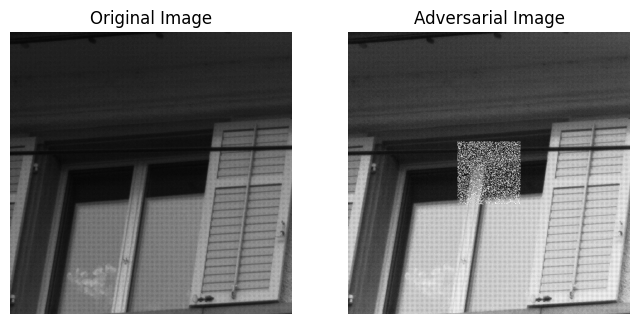

In [105]:
# EXTRA CODE BLOCK 3 - Single image random patch attack, no SSIM

# THIS CODE GENERATES A RANDOMIZED PATCH of a given size (patch_size) and at the center of the input image
# This does not incorporate SSIM into the loss function
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

def create_adversarial_image(original_image, patch_size=30):
    """
    Create an adversarial image by adding a random grayscale patch to the Bayer image.

    Args:
        original_image (np.ndarray): The original RAW image of shape (448, 448).
        patch_size (int): The size of the adversarial patch.

    Returns:
        np.ndarray: The adversarial image in RAW format.
    """
    # Convert the original image to a Bayer image
    bayer_image = np.array(Image.fromarray(original_image).convert('L'))

    # Generate a random grayscale patch
    patch = np.random.rand(patch_size, patch_size) * 255
    patch = patch.astype(np.uint8)

    # Determine the center coordinates of the patch
    height, width = bayer_image.shape
    center_h = height // 2
    center_w = width // 2

    # Create a new image with the patch added
    adv_image = np.copy(bayer_image)
    adv_image_patch = np.zeros_like(bayer_image)
    adv_image_patch[center_h - patch_size // 2:center_h + patch_size // 2, center_w - patch_size // 2:center_w + patch_size // 2] = patch
    adv_image = np.maximum(adv_image, adv_image_patch)

    # Convert the adversarial image back to RAW format
    # adv_image_raw = np.array(Image.fromarray(adv_image).convert('RGB'))

    return adv_image

# Load the original RAW image
original_image = np.array(Image.open('/content/drive/MyDrive/p9/ZRR_Dataset/1157.png'))

# Create the adversarial image
adv_image = create_adversarial_image(original_image, patch_size=100)


# Display the original and adversarial images
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.imshow(original_image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(adv_image, cmap='gray')
plt.title('Adversarial Image')
plt.axis('off')

plt.show()


In [ ]:
# EXTRA CODE BLOCK 4 - Full dataset single image random patch attack, no SSIM

# RANDOM PATCH FOR DATASET
# This does not incorporate SSIM into the loss function


import tensorflow as tf
import numpy as np
from PIL import Image
import os
import torch
from pytorch_msssim import SSIM
import matplotlib.pyplot as plt

def generate_adversarial_example(original_image, eps, steps):
    """
    Generate an adversarial example using the Fast Gradient Sign Method (FGSM) with SSIM loss.

    Args:
        original_image (np.ndarray): The original grayscale RAW image of shape (448, 448).
        eps (float): The maximum perturbation size.
        steps (int): The number of gradient descent steps to perform.

    Returns:
        np.ndarray: The adversarial example.
    """
    # Convert the image to a TensorFlow tensor
    original_image_tensor = tf.expand_dims(tf.expand_dims(tf.convert_to_tensor(original_image, dtype=tf.float32), axis=0), axis=-1)

    # Initialize the perturbation tensor
    perturbation = tf.zeros_like(original_image_tensor)

    # Perform the FGSM attack with SSIM loss
    for _ in range(steps):
        with tf.GradientTape() as tape:
            tape.watch(perturbation)

            # Construct the adversarial example
            adversarial_image = tf.clip_by_value(original_image_tensor + perturbation, 0.0, 1.0)

            # Calculate the SSIM loss
            ssim_loss = 1.0 - tf.image.ssim(original_image_tensor, adversarial_image, max_val=1.0)

        # Calculate the gradients of the loss with respect to the perturbation
        gradients = tape.gradient(ssim_loss, perturbation)

        # Update the perturbation
        perturbation += tf.sign(gradients) * eps
        perturbation = tf.clip_by_value(perturbation, -eps, eps)

    # Return the adversarial example
    return (original_image_tensor + perturbation)[0, :, :, 0].numpy()

# Load the dataset from the 'test_raw' folder
dataset_dir = '/content/drive/MyDrive/p9/ZRR_Dataset/sub_RAW'
image_files = sorted([f for f in os.listdir(dataset_dir) if f.endswith('.png')])
attacked_images = {}

for image_file in image_files:
    # Load the original image
    original_image = Image.open(os.path.join(dataset_dir, image_file))
    bayer_image = np.array(original_image.convert('L'))

    # Generate the adversarial example
    adversarial_image = generate_adversarial_example(bayer_image, eps=0.88, steps=50)

    # Save the adversarial image
    image_id = os.path.splitext(image_file)[0]
    adversarial_image_pil = Image.fromarray((adversarial_image * 255).astype(np.uint8), mode='L')
    adversarial_image_pil.save(f'/content/drive/MyDrive/p9/ZRR_Dataset/attacked_images/{image_id}.png')

    # Store the adversarial image in the dictionary
    attacked_images[image_id] = adversarial_image

# Plot the attacked images
num_images = len(attacked_images)
num_rows = (num_images + 3) // 4  # Calculate the number of rows needed
fig, axs = plt.subplots(num_rows, 4, figsize=(16, 4 * num_rows))

for i, (image_id, attacked_image) in enumerate(attacked_images.items()):
    row, col = i // 4, i % 4
    axs[row, col].imshow(attacked_image, cmap='gray')
    axs[row, col].set_title(f'Attacked Image {image_id}')
    axs[row, col].axis('off')

# Remove any unused subplots
for i in range(num_images, num_rows * 4):
    row, col = i // 4, i % 4
    fig.delaxes(axs[row, col])

plt.tight_layout()
plt.show()


# THIS IS THE END OF RELEVANT CODE, THE REST OF THIS NOTEBOOK WAS USED AS EXPERIMENTATION AND IS PROVIDED FOR YOUR CONVENIENCE AND TO ANALYZE OTHER ASPECTS OF THIS PROJECT WHICH MAY SERVE AS BACKGROUND KNOWLEDGE OR INSIGHT. ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [3]:
pretrained_model = tf.keras.applications.MobileNetV2(include_top=True,
                                                     weights='imagenet')
pretrained_model.trainable = False

# ImageNet labels
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

14536120/14536120 [==============================] - 0s 0us/step


In [5]:
import sys
sys.path.append('/content/drive/MyDrive/p9/skyb-aim2020-public/')

from model import PyNetCA

pca_instance = PyNetCA()
# Use the PCA class methods

In [4]:
# Helper function to preprocess the image so that it can be inputted in MobileNetV2
def preprocess(image):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, (224, 224))
  image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
  image = image[None, ...]
  return image

# Helper function to extract labels from probability vector
def get_imagenet_label(probs):
  return decode_predictions(probs, top=1)[0][0]

## Original image
Let's use a sample image of a [Labrador Retriever](https://commons.wikimedia.org/wiki/File:YellowLabradorLooking_new.jpg) by Mirko [CC-BY-SA 3.0](https://creativecommons.org/licenses/by-sa/3.0/) from Wikimedia Common and create adversarial examples from it. The first step is to preprocess it so that it can be fed as an input to the MobileNetV2 model.

In [7]:
#image_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
#image_path = '/root/acorn.jpeg'
image_path = '/content/drive/MyDrive/p9/ZRR_Dataset/1157_e.png'
image_num = 1157
image_raw = tf.io.read_file(image_path)

image = tf.image.decode_image(image_raw)
#image = tf.image.decode_image(image_raw, channels=1)  # Decode as grayscale
# Convert grayscale to RGB
#image = tf.image.grayscale_to_rgb(image)

original_image_shape = tf.shape(image)
print("Original image shape: ", original_image_shape)
image = preprocess(image)
print("Preprocessed image shape: ", tf.shape(image))

image_probs = pretrained_model.predict(image)

Original image shape:  tf.Tensor([448 448   3], shape=(3,), dtype=int32)
Preprocessed image shape:  tf.Tensor([  1 224 224   3], shape=(4,), dtype=int32)
1/1 [==============================] - 4s 4s/step


In [6]:
!pip install -q pytorch_msssim

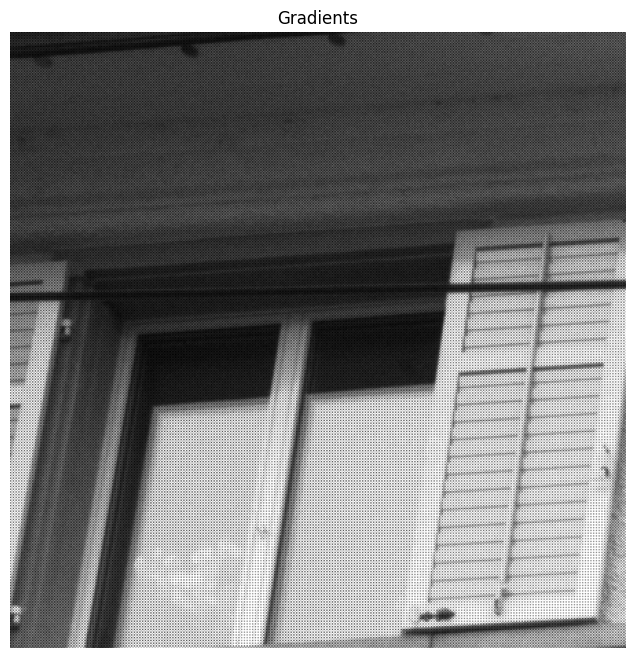

In [74]:
import tensorflow as tf
import numpy as np
from PIL import Image
import torch
import matplotlib.pyplot as plt

def create_adversarial_pattern_PATCH(input_image, patch_size):
    with tf.GradientTape() as tape:
        tape.watch(input_image)

        # Construct the adversarial patch
        height, width = input_image.shape[0], input_image.shape[1]
        channels = 1
        center_h = height // 2
        center_w = width // 2
        perturbation_mask = np.zeros_like(input_image)
        perturbation_mask[center_h - patch_size // 2:center_h + patch_size // 2 + 1, center_w - patch_size // 2:center_w + patch_size // 2 + 1] = 1
        perturbation = tape.gradient(tf.reduce_mean(tf.square(input_image)), input_image) * perturbation_mask

        # Calculate the MSE loss
        adversarial_image = tf.clip_by_value(input_image + perturbation, 0.0, 1.0)
        loss = tf.reduce_mean(tf.square(input_image - adversarial_image))

    # Get the gradients in a 2D format
    gradients = perturbation

    return gradients

# Load the original image
original_image = Image.open('/content/drive/MyDrive/p9/ZRR_Dataset/1157.png')
bayer_image = np.array(original_image.convert('L')).astype(np.float32)

# Generate the adversarial patch
patch_size = 448
height = 224
width = 224
gradients = create_adversarial_pattern_PATCH(tf.convert_to_tensor(bayer_image), patch_size)

# Visualize the gradients
plt.figure(figsize=(8, 8))
plt.imshow(gradients, cmap='gray')
plt.axis('off')
plt.title('Gradients')
plt.show()


SSIM: 0.7564500570297241


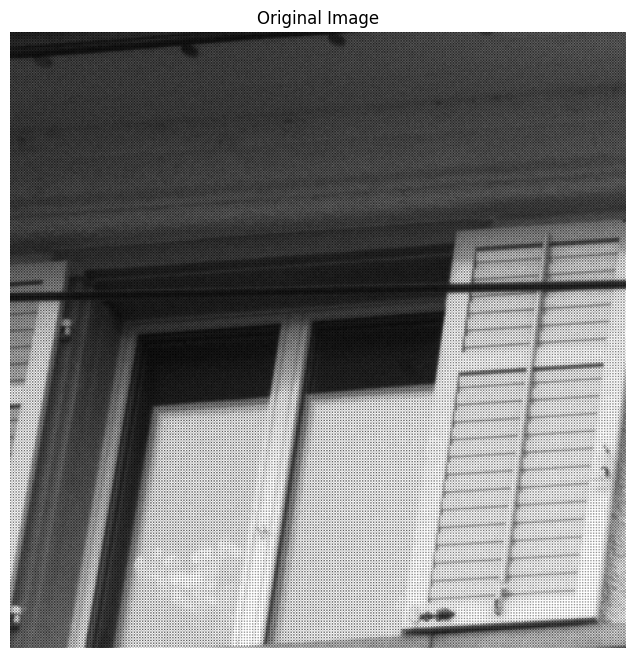

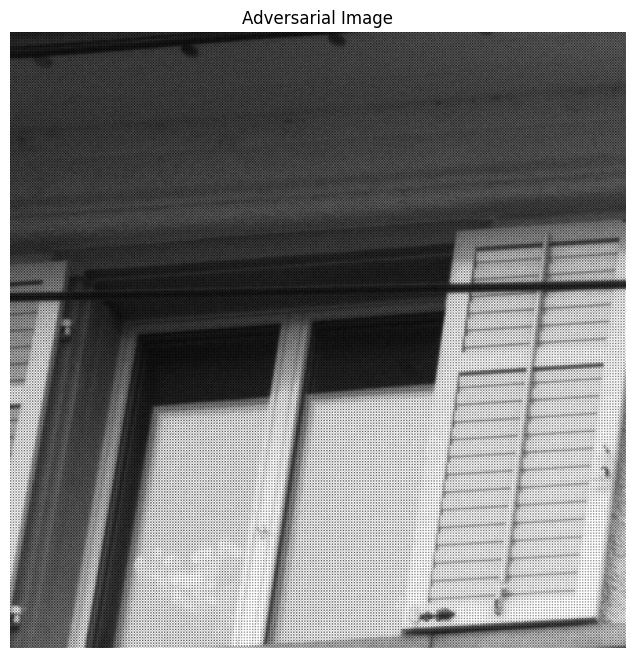

In [108]:
import tensorflow as tf
import numpy as np
from PIL import Image
import torch

def generate_adversarial_example(original_image, eps, steps):
    """
    Generate an adversarial example using the Fast Gradient Sign Method (FGSM) with MSE loss.

    Args:
        original_image (np.ndarray): The original grayscale RAW image of shape (448, 448).
        eps (float): The maximum perturbation size.
        steps (int): The number of gradient descent steps to perform.

    Returns:
        np.ndarray: The adversarial example.
    """
    # Convert the image to a TensorFlow tensor
    original_image_tensor = tf.expand_dims(tf.expand_dims(tf.convert_to_tensor(original_image, dtype=tf.float32), axis=0), axis=-1)

    # Initialize the perturbation tensor
    perturbation = tf.zeros_like(original_image_tensor)

    # Perform the FGSM attack with MSE loss
    for _ in range(steps):
        with tf.GradientTape() as tape:
            tape.watch(perturbation)

            # Construct the adversarial example
            adversarial_image = tf.clip_by_value(original_image_tensor + perturbation, 0.0, 1.0)

            # Calculate the MSE loss
            loss = tf.reduce_mean(tf.square(original_image_tensor - adversarial_image))

        # Calculate the gradients of the loss with respect to the perturbation
        gradients = tape.gradient(loss, perturbation)

        # Update the perturbation
        perturbation += tf.sign(gradients) * eps
        perturbation = tf.clip_by_value(perturbation, -eps, eps)

    # Return the adversarial example
    return (original_image_tensor + perturbation)[0, :, :, 0].numpy()

# Load the original image
original_image = Image.open('/content/drive/MyDrive/p9/ZRR_Dataset/1157.png')
bayer_image = np.array(original_image.convert('L'))

# Generate the adversarial example
adversarial_image = generate_adversarial_example(bayer_image, eps=0.65, steps=500)

# Load the ground truth image
bayer_tensor = torch.from_numpy(bayer_image).unsqueeze(0).unsqueeze(0).float()

# Compute the SSIM between the adversarial example and the ground truth
adversarial_tensor = torch.from_numpy(np.array(adversarial_image).transpose(1, 0)).unsqueeze(0).unsqueeze(0).float()
#adversarial_tensor = adversarial_tensor.repeat(1, 3, 1, 1)

# Initialize the SSIM module
ssim_module = SSIM(data_range=1.0, size_average=True, channel=1)
ssim_value = ssim_module(adversarial_tensor, bayer_tensor)
print(f"SSIM: {ssim_value.item()}")

# Display the original image
plt.figure(figsize=(8, 8))
plt.imshow(bayer_image, cmap='gray')
plt.axis('off')
plt.title('Original Image')
plt.show()

# Display the adversarial image
plt.figure(figsize=(8, 8))
plt.imshow(adversarial_image, cmap='gray')
plt.axis('off')
plt.title('Adversarial Image')
plt.show()


In [101]:
import torch
import torch.nn.functional as F
from pytorch_msssim import ssim, ms_ssim, SSIM, MS_SSIM
from PIL import Image
import numpy as np

def compute_ssim_grayscale(img1, img2):
    """
    Compute the SSIM between two grayscale images.

    Args:
        img1 (torch.Tensor): The first grayscale image tensor of shape (1, 1, height, width).
        img2 (torch.Tensor): The second grayscale image tensor of shape (1, 1, height, width).

    Returns:
        torch.Tensor: The SSIM value.
    """
    ssim_module = SSIM(data_range=1.0, size_average=True, channel=1)
    ssim_value = ssim_module(img1, img2)
    return ssim_value

# Load the images
img1 = Image.open('/content/drive/MyDrive/p9/ZRR_Dataset/1157.png')
img2 = Image.open('/content/drive/MyDrive/p9/ZRR_Dataset/1157.png')

# Convert the images to grayscale
img1_grayscale = np.array(img1.convert('L'))
img2_grayscale = np.array(img2.convert('L'))

# Convert the grayscale images to PyTorch tensors
img1_tensor = torch.from_numpy(img1_grayscale).unsqueeze(0).unsqueeze(0).float()
img2_tensor = torch.from_numpy(img2_grayscale).unsqueeze(0).unsqueeze(0).float()

# Compute the SSIM for the grayscale images
ssim_value = compute_ssim_grayscale(img1_tensor, img2_tensor)
print(f"SSIM: {ssim_value.item()}")



SSIM: 1.0


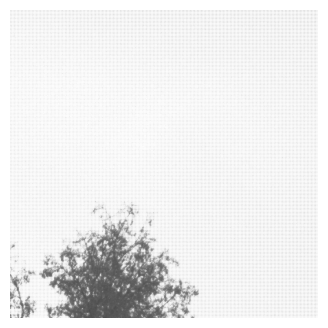

In [31]:
# DISPLAY SINGLE IMAGE
from PIL import Image
import matplotlib.pyplot as plt

# Load the image
image = Image.open('/content/drive/MyDrive/p9/ZRR_Dataset/1157.png')

# Display the image using Matplotlib
plt.imshow(image)
plt.axis('off')
plt.show()


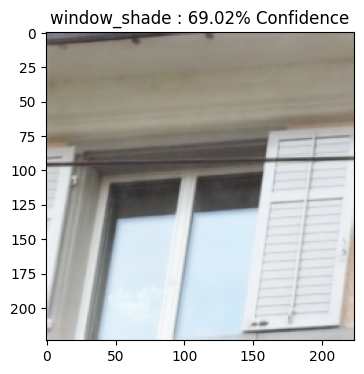

In [44]:
plt.figure()
plt.imshow(image[0] * 0.5 + 0.5)  # To change [-1, 1] to [0,1]
_, image_class, class_confidence = get_imagenet_label(image_probs)
plt.title('{} : {:.2f}% Confidence'.format(image_class, class_confidence*100))
plt.show()

## Create the adversarial image

### Implementing fast gradient sign method
The first step is to create perturbations which will be used to distort the original image resulting in an adversarial image. As mentioned, for this task, the gradients are taken with respect to the image.

In [45]:
loss_object = tf.keras.losses.CategoricalCrossentropy()

def create_adversarial_pattern_PATCH(input_image, input_label, patch_size):
  with tf.GradientTape() as tape:
    tape.watch(input_image)
    prediction = pretrained_model(input_image)
    loss = loss_object(input_label, prediction)
    print("loss = ", loss)

  # Get the gradients of the loss w.r.t to the input image.
  gradient = tape.gradient(loss, input_image)

  # Get the sign of the gradients to create the perturbation
  signed_grad = tf.sign(gradient)

  # Apply the perturbation only on the specified patch size
  height, width, channels = signed_grad.shape[1:4]
  center_h = height // 2
  center_w = width // 2
  patch_radius = patch_size // 2
  perturbation_mask = np.zeros_like(signed_grad[0])
  perturbation_mask[center_h - patch_radius:center_h + patch_radius + 1, center_w - patch_radius:center_w + patch_radius + 1, :] = 1
  signed_grad = signed_grad * perturbation_mask

  return signed_grad

The resulting perturbations can also be visualised.

loss =  tf.Tensor(0.370763, shape=(), dtype=float32)


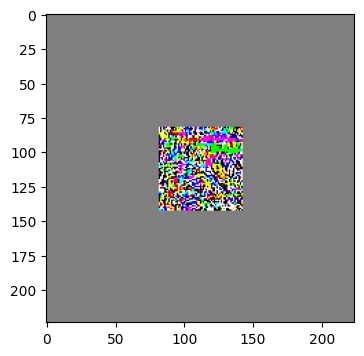

In [46]:
# Get the input label of the image.
window_shade_index = 905
label = tf.one_hot(window_shade_index, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))

patch_size = 60
perturbations = create_adversarial_pattern_PATCH(image, label, patch_size)
plt.imshow(perturbations[0] * 0.5 + 0.5);  # To change [-1, 1] to [0,1]

Let's try this out for different values of epsilon and observe the resultant image. You'll notice that as the value of epsilon is increased, it becomes easier to fool the network. However, this comes as a trade-off which results in the perturbations becoming more identifiable.

In [50]:
def display_images(images, descriptions):
  num_images = len(images)
  num_rows = (num_images + 3) // 4  # Calculate the number of rows needed

  fig, axs = plt.subplots(num_rows, 4, figsize=(16, 4 * num_rows))  # Create a figure with multiple subplots

  for i, (image, description) in enumerate(zip(images, descriptions)):
    row, col = i // 4, i % 4  # Calculate the row and column indices
    _, label, confidence = get_imagenet_label(pretrained_model.predict(image))

    axs[row, col].imshow(image[0] * 0.5 + 0.5)
    axs[row, col].set_title('{} \n {} : {:.2f}% Confidence'.format(description, label, confidence * 100))
    axs[row, col].axis('off')

  # Remove any unused subplots
  for i in range(num_images, num_rows * 4):
    row, col = i // 4, i % 4
    fig.delaxes(axs[row, col])

  plt.tight_layout()
  plt.show()

1/1 [==============================] - 0s 22ms/step


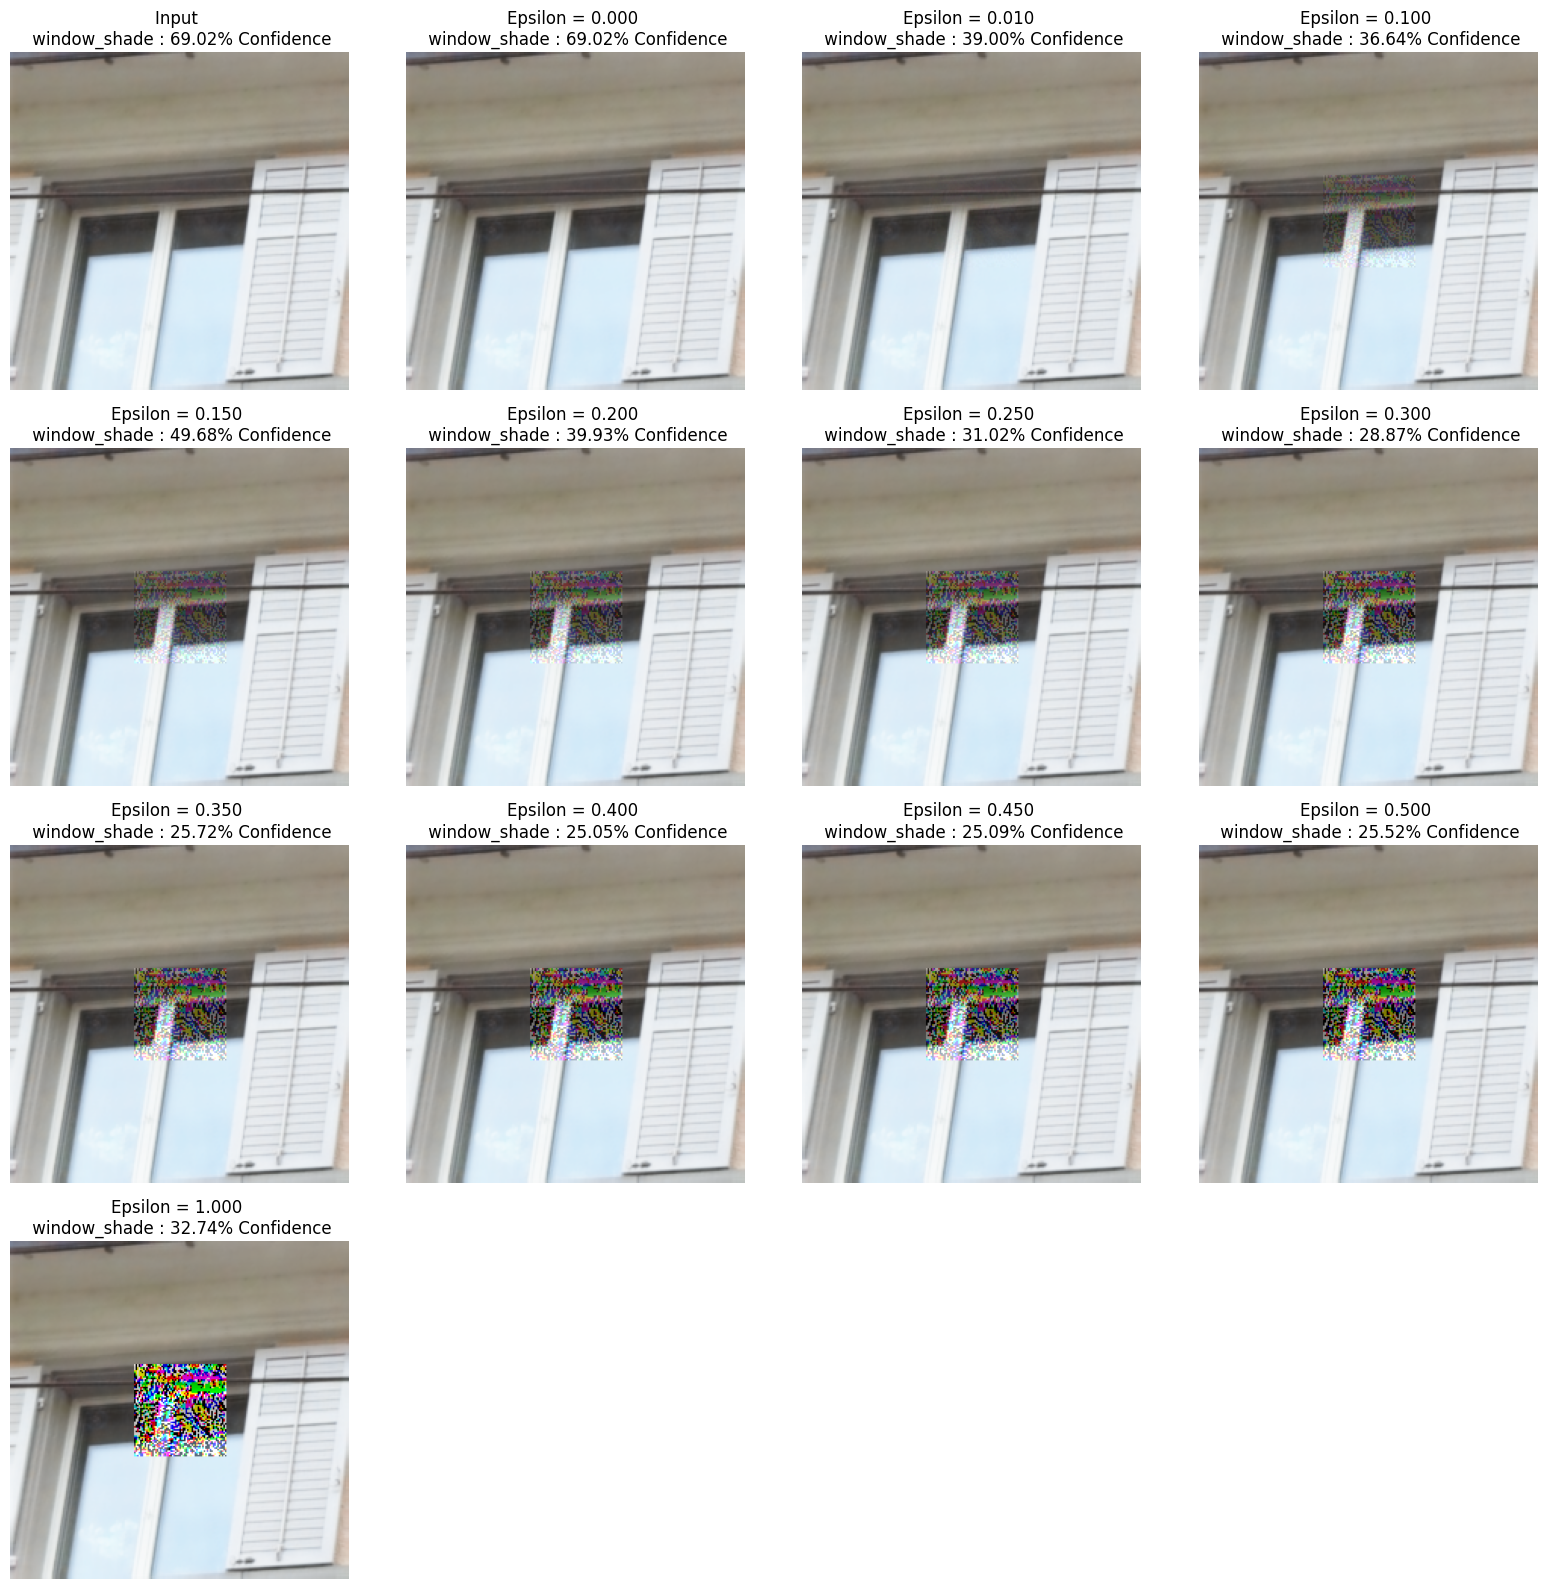

In [51]:
epsilons = [0, 0.01, 0.1, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 1.0]
#epsilons = [0.15, 0.20, 0.25, 0.50]
descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input') for eps in epsilons]

images = [image]
descriptions = ['Input']  # Initialize the descriptions list with 'Input'

for eps in epsilons:
  adv_x = image + eps * (perturbations)
  adv_x = tf.clip_by_value(adv_x, -1, 1)
  images.append(adv_x)
  descriptions.append(f'Epsilon = {eps:.3f}')  # Add the description for the current epsilon

display_images(images, descriptions)

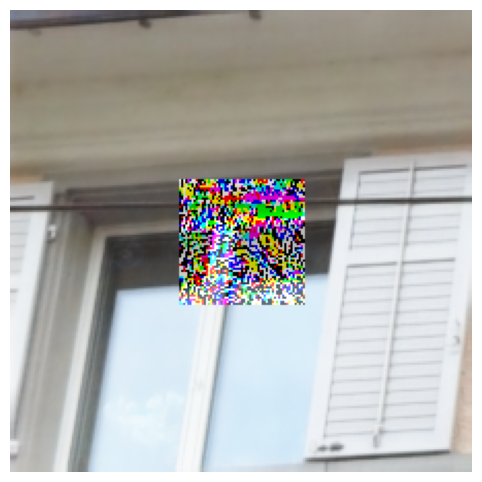

In [58]:
# Display a single image index
import matplotlib.pyplot as plt

def plot_single_image(images, index):
    plt.figure(figsize=(8, 6))
    plt.imshow(images[index][0] * 0.5 + 0.5)
    plt.axis('off')
    plt.show()

plot_single_image(images, 12)

In [59]:
def undo_preprocessing(preprocessed_image, original_image_shape):
    # 1. Remove the batch dimension
    image = tf.squeeze(preprocessed_image, axis=0)

    # 2. Undo the MobileNetV2 preprocessing
    image = (image + 1) / 2  # Undo the normalization
    image = image * 255.0  # Scale the pixel values back to the original range

    # 3. Undo the resizing
    image = tf.image.resize(image, original_image_shape[:-1])

    # 4. Undo the type casting
    image = tf.cast(image, tf.uint8)

    return image

# Undo the preprocessing
restored_image = undo_preprocessing(images[12], original_image_shape)

print(f"Original image shape: {original_image_shape}")
print("Preproccesed image shape: ", tf.shape(images[12]))
print(f"Restored image shape: {tf.shape(restored_image)}")

Original image shape: [448 448   3]
Preproccesed image shape:  tf.Tensor([  1 224 224   3], shape=(4,), dtype=int32)
Restored image shape: [448 448   3]


In [60]:
import os
from google.colab import drive
from PIL import Image
import tensorflow as tf

# Save the restored image to Google Drive
restored_image_path = '/content/drive/MyDrive/p9/ZRR_Dataset/' + str(image_num) + '_adv.png'
Image.fromarray(restored_image.numpy().astype(np.uint8)).save(restored_image_path)

In [19]:
import torch
import torch.nn.functional as F
from pytorch_msssim import ssim, ms_ssim, SSIM, MS_SSIM

def compute_ssim(img1, img2):
    ssim_value = ssim(img1, img2, data_range=1.0, size_average=True)
    return ssim_value

# Load the images
img1 = Image.open('/content/drive/MyDrive/p9/ZRR_Dataset/1157_e.png')
img2 = Image.open('/content/drive/MyDrive/p9/ZRR_Dataset/1157_gt.jpg')

# Convert the images to PyTorch tensors
img1_tensor = torch.from_numpy(np.array(img1).transpose(2, 0, 1)).unsqueeze(0).float()
img2_tensor = torch.from_numpy(np.array(img2).transpose(2, 0, 1)).unsqueeze(0).float()
ssim_value = compute_ssim(img1_tensor, img2_tensor)
print(f"SSIM: {ssim_value.item()}")

SSIM: 0.44563373923301697


In [32]:
import numpy as np
from skimage.metrics import structural_similarity
from skvideo.measure import msssim

# Paths
image_pynet_path = '/content/drive/MyDrive/p9/ZRR_Dataset/1157_e.png'
image_gt_path = '/content/output.jpg'

# Load pynet enhanced
image_pynet_raw = tf.io.read_file(image_pynet_path)
image_pynet = tf.image.decode_image(image_pynet_raw)

# Load ground truth
image_gt_raw = tf.io.read_file(image_gt_path)
image_gt = tf.image.decode_image(image_gt_raw)

# Convert images to float data type
image_pynet = image_pynet.astype(np.float32) / 255.0
image_gt = image_gt.astype(np.float32) / 255.0

# Compute MS-SSIM
ms_ssim_value = msssim(image_pynet, image_gt, max_val=1.0)
print(f"MS-SSIM: {ms_ssim_value}")

ModuleNotFoundError: No module named 'skvideo'

In [66]:
# FOR RGB IMAGES
from skimage import io
from skimage.metrics import structural_similarity

# Load reference and distorted RGB images from paths
reference_image_path = '/content/drive/MyDrive/p9/ZRR_Dataset/1157_e.png'
distorted_image_path = '/content/drive/MyDrive/p9/ZRR_Dataset/1157_adv.png'

reference_image = io.imread(reference_image_path)
distorted_image = io.imread(distorted_image_path)

# Calculate SSIM for each channel
ssim_r = structural_similarity(reference_image[:, :, 0], distorted_image[:, :, 0], channel_axis=-1)
ssim_g = structural_similarity(reference_image[:, :, 1], distorted_image[:, :, 1], channel_axis=-1)
ssim_b = structural_similarity(reference_image[:, :, 2], distorted_image[:, :, 2], channel_axis=-1)

# Calculate average SSIM
ssim_avg = (ssim_r + ssim_g + ssim_b) / 3
print(f"Average SSIM: {ssim_avg}")

Average SSIM: 0.9158261168804799


In [ ]:
from skimage import io
from skimage.metrics import structural_similarity
from skimage.transform import resize

# Load reference and distorted grayscale images from paths
reference_image_path = '/content/drive/MyDrive/p9/ZRR_Dataset/1157_gt.jpg'
distorted_image_path = '/content/drive/MyDrive/p9/ZRR_Dataset/1157_e.png'
#distorted_image_path = '/content/output.png'

# Load grayscale images
reference_image = io.imread(reference_image_path)
distorted_image = io.imread(distorted_image_path)

# Print the shapes of the loaded images
print("Reference image shape:", reference_image.shape)
print("Distorted image shape:", distorted_image.shape)

# Resize the reference image to match the distorted image dimensions
#reference_image = resize(reference_image, distorted_image.shape, anti_aliasing=True)

# Print the shapes after resizing
print("Reference image shape after resizing:", reference_image.shape)
print("Distorted image shape:", distorted_image.shape)

# Calculate SSIM for grayscale images
ssim_value = structural_similarity(reference_image, distorted_image, channel_axis=-1)
print(f"SSIM: {ssim_value}")